In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_path = '/content/drive/MyDrive/CV nâng cao/Bài tập trên lớp/Tuần 1/data'


In [ ]:
import os

folders = ['Bike', 'Car']

for folder in folders:
  folder_path = os.path.join(data_path, folder)
  num_files = 0

  if os.path.exists(folder_path) and os.path.isdir(folder_path):
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        if os.path.isfile(file_path):
            num_files += 1
    print(f'The folder "{folder}" contains {num_files} files.')
  else:
    print(f'The folder "{folder}" does not exist or is not a directory.')


The folder "Bike" contains 200 files.
The folder "Car" contains 200 files.


In [ ]:
import numpy as np
import os
import cv2
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torchvision.transforms as transforms
import torch
import torch.nn as nn
from PIL import Image
import torchvision.models as models
from tqdm import tqdm

folders = ['Bike', 'Car']

# Load the pre-trained AlexNet model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vgg16 = models.vgg16(pretrained=True).to(device)
vgg16.eval()  # Chuyển sang chế độ đánh giá (không huấn luyện lại)

# **2. Loại bỏ phần phân loại, chỉ giữ lại phần feature extractor**
feature_extractor = nn.Sequential(*list(vgg16.children())[:2])  # Bỏ lớp FC
feature_extractor.to(device)

# Define image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Process images and extract features
features_data = []
for folder in folders:
    folder_path = os.path.join(data_path, folder)
    if os.path.exists(folder_path) and os.path.isdir(folder_path):
        for filename in tqdm(os.listdir(folder_path)):
            if filename.endswith(('.jpg', '.jpeg', '.png')): # Add more image extensions if needed
                file_path = os.path.join(folder_path, filename)
                try:
                    img = Image.open(file_path).convert('RGB') # Handle potential image format issues
                    img_tensor = transform(img)
                    img_tensor = img_tensor.unsqueeze(0)  # Add batch dimension

                    with torch.no_grad():
                        features = feature_extractor(img_tensor)

                    features_data.append({
                        'filename': filename,
                        'folder': folder,
                        'features': features.numpy() # Convert to numpy array for easier handling
                    })

                except Exception as e:
                    print(f"Error processing {filename}: {e}")
    else:
        print(f'The folder "{folder}" does not exist or is not a directory.')

# Now features_data contains the extracted features for each image along with filename and folder
print(f"Total images processed: {len(features_data)}")

# Example of accessing the features for the first image
#print(features_data[0]['features'].shape) # Check the shape of the extracted features
#print(features_data[0]['filename'])




/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 200/200 [02:04<00:00,  1.60it/s]

Total images processed: 400


In [ ]:
vgg16


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Extract features and labels
X = np.array([item['features'].flatten() for item in features_data])
y = np.array([0 if item['folder'] == 'Bike' else 1 for item in features_data])

# Split data into training and testing sets (70/30 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train an SVM classifier
svm_classifier = SVC(kernel='linear')  # You can experiment with different kernels
svm_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = svm_classifier.predict(X_test)

In [ ]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")

Accuracy: 0.9916666666666667
Precision: 0.9830508474576272
Recall: 1.0
F1-score: 0.9914529914529915


In [ ]:
# Classification Report

cf = classification_report(y_test, y_pred, target_names=['Bike', 'Car'])

print(cf)

              precision    recall  f1-score   support

        Bike       1.00      0.98      0.99        62
         Car       0.98      1.00      0.99        58

    accuracy                           0.99       120
   macro avg       0.99      0.99      0.99       120
weighted avg       0.99      0.99      0.99       120



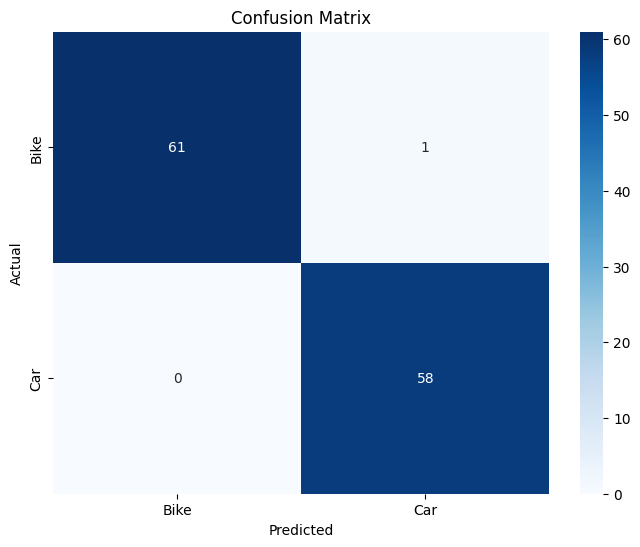

In [ ]:
# Confusion Matrix Visualization
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Bike', 'Car'], yticklabels=['Bike', 'Car'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()